# MAP433 - DM1

### Groupe 43 : CHEN YUNHAO & LAHIANI MAZIGH & WANG XIAOZHEN  

In [4]:
import numpy as np
import scipy.special as scm
from pylab import *
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import scipy.stats as sts

In [5]:
dataset = pd.read_csv ('./ozone_complet.txt', delimiter=";", header=0)#, index_col = [0, 1], names=["x","y"])
index_with_nan = dataset.index[dataset.isnull().any(axis=1)]
N = len(dataset)
dataset["intercept"] =  np.ones(N)
dataset = dataset.copy()
dataset.drop(index_with_nan,0, inplace=True)
Y = dataset["maxO3"]
Z = dataset[["intercept", "T12", "Vx", "Ne12"]]
Zn = Z.to_numpy()
Yn = Y.to_numpy()

## Préambule : 
Ici nous utilisons une bibliothèque qui facilite les calcules, nous vérifions que les résultats que nous obtenons concordent bien.
le modele n'est pas exactement le même car le modèle de cette bibliothèque fixe la variance à 1.
Mais les resultats ne sont pas trés éloignés des notres. (Beta est exactement le même car il ne depend pas de la variance)

In [6]:
#calcule avec bibli
model = sm.OLS(Y, Z).fit()
predictions = model.predict(Z) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  maxO3   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     358.0
Date:                Thu, 17 Sep 2020   Prob (F-statistic):          2.26e-171
Time:                        20:57:15   Log-Likelihood:                -5830.7
No. Observations:                1366   AIC:                         1.167e+04
Df Residuals:                    1362   BIC:                         1.169e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     73.7349      3.074     23.990      0.0

## Question 1 :


In [13]:
#Calcule à la main 
ZZ = np.linalg.inv(Zn.T.dot(Zn))
Proj = ZZ.dot(Zn.T)
BetaE = Proj.dot(Yn)
print("Par l'estimation des moindres carrés (et du maximum de vraisemblance pour la variance), on a : \n")
print("\t Beta = ", BetaE)


#Estimation de la variance 
H = Zn.dot(Proj)
VarianceE = np.linalg.norm(Yn - H.dot(Yn)) ** 2 / (N - 4) # ici Q vaut 4 
print("\t Variance = ", VarianceE)

Par l'estimation des moindres carrés (et du maximum de vraisemblance pour la variance), on a : 

	 Beta =  [73.73485559  1.53554077  1.32091586 -3.30686121]
	 Variance =  279.3522810116052


## Question 2 :


In [8]:
I4 = np.eye(4)
#On utilisera ici la question 19
Beta1 = I4[0]*BetaE
interval = np.zeros((4,2))
#Test : 
qAlpha = sts.t.ppf(0.95, df=N-4)
for i in range(4):
     #choose the quatile
    constant = I4[i].dot(BetaE)
    v = qAlpha * np.sqrt(VarianceE * I4[i].dot(ZZ).dot(I4[i].T))
    interval[i] = np.array([constant - v, constant + v])

print("En utilisant la question 19 du DM, on construit des intervalles de confiance à 95% pour Beta: \n")
print(interval)

En utilisant la question 19 du DM, on construit des intervalles de confiance à 95% pour Beta: 

[[68.84877721 78.62093398]
 [ 1.35821626  1.71286527]
 [ 1.08159228  1.56023944]
 [-3.7080894  -2.90563301]]


## Question 3:

Ici nous utiliserons la loi de Fisher developpée aux questions 22 & 23.
L'idée est de discrétiser l'espace autour des intervale de confiance de la question 2, et de 
verifier si la barre des 95% de confiance est respectée pour ces points.

In [9]:
qantilF = sts.f.ppf(0.95,dfn=2,dfd=N-4)

def TestRejet(R, bt1, bt2, bt3, bt4): 
    results = np.zeros(len(bt1))
    c0 = np.linalg.inv(R.dot(ZZ).dot(R.T))
    for i in range(len(bt1)):
        betaT = np.array([bt1[i], bt2[i], bt3[i], bt4[i]])
        c1 = R.dot(BetaE - betaT)
        fisher = c1.T.dot(c0).dot(c1) / (2 * VarianceE)
        if(np.abs(fisher) > qantilF):
            results[i] = 0
        else :
            results[i] = 1
            
    return results

#Utilisons ici la question 23 : 
R12 = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R13 = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

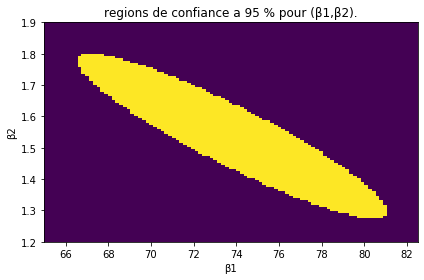

In [10]:
b1 = linspace(65, 82.5, 100)
b2 = linspace(1.2, 1.9, 100)
b3 = linspace(0.9, 1.7, 100)
B1, B2 = meshgrid(b1, b2)

#les reshape me simplifie la vie
B2tmp = B2.reshape(10000,1)
B1tmp = B1.reshape(10000, 1)
Z = TestRejet(R12, B1tmp, B2tmp, np.zeros(len(B1tmp)), np.zeros(len(B1tmp)) )# calcul du tableau des valeurs de Z
Z = Z.reshape(100, 100)


#Ques du plot, peu d'interet
fig, ax0 = plt.subplots(1, 1)

c = ax0.pcolor(B1, B2, Z)
ax0.set_title('regions de confiance a 95 % pour (β1,β2).')
ax0.set_xlabel('β1')
ax0.set_ylabel('β2')
fig.tight_layout()
plt.show()

show()

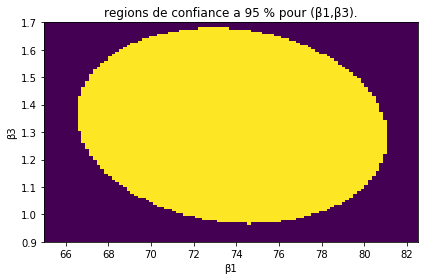

In [11]:

B1, B3 = meshgrid(b1, b3)

#les reshape me simplifie la vie
B3tmp = B3.reshape(10000,1)
B1tmp = B1.reshape(10000, 1)

Z = TestRejet(R13, B1tmp, np.zeros(len(B1tmp)), B3tmp, np.zeros(len(B1tmp)))

Z = Z.reshape(100, 100)


fig, ax0 = plt.subplots(1, 1)

c = ax0.pcolor(B1, B3, Z)
ax0.set_title('regions de confiance a 95 % pour (β1,β3).')
ax0.set_xlabel('β1')
ax0.set_ylabel('β3')
fig.tight_layout()
plt.show()


## Question 4 :

Nous allons développer ici deux approches : 
La premiere, simple, consiste à suivre l'énoncé et regarder le test de la question 20, et à admettre l'équivalence 
$x_i$ n'influence pas O3 alors $\beta_i = 0$
pour $ x_3 = (0, 0, 1, 0)$, $ x_4 = (0, 0, 0, 1)$, $ x_{23} = (0, 1, 1, 0)$
 
 On pourra alors faire un test à 95%, ou bien, mieux, on pourra étudier la $p-valeur$ de ce Test et décidé si on rejete ou pas :

## Question 5 :

In [12]:
X3 = np.array([0, 0, 1, 0])
X4 = np.array([0, 0, 1, 0])
X23 = np.array([0, 1, 1, 0])


#Test X3 :
T = X3.T.dot(BetaE)/(np.sqrt(VarianceE*X3.T.dot(ZZ).dot(X3)))
p_valeur = (1 - sts.t.cdf(np.abs(T), df=N-4)) * 2
print("p valuer pour Test 1 : independance entre O3 et Vx :", p_valeur)

#Test X4 :
T = X4.T.dot(BetaE)/(np.sqrt(VarianceE*X4.T.dot(ZZ).dot(X4)))
p_valeur = (1 - sts.t.cdf(np.abs(T), df=N-4)) * 2
print("p valuer pour Test 1 : independance entre O3 et Ne12 :",p_valeur)

#Test X23 :
T = X23.T.dot(BetaE)/(np.sqrt(VarianceE*X23.T.dot(ZZ).dot(X23)))
p_valeur = (1 - sts.t.cdf(np.abs(T), df=N-4)) * 2
print("p valuer pour Test 1 : independance entre O3 et Vx ou T12:",p_valeur)

p valuer pour Test 1 : independance entre O3 et Vx : 0.0
p valuer pour Test 1 : independance entre O3 et Ne12 : 0.0
p valuer pour Test 1 : independance entre O3 et Vx ou T12: 0.0


## Question 6 :

On a bien sûr rejet des trois hypothèses d'indépendance, et donc on peut dire avec une très grande probabilité que les paramètres Vx, ne12, Vx ou T12 influences bien la valeur d'O3.
